In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 11.5MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 1.1MB 52.8MB/s 
     |████████████████████████████████| 194kB 54.1MB/s 
     |████████████████████████████████| 40kB 7.3MB/s 
     |████████████████████████████████| 92kB 13.6MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 2.6MB 46.1MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

THe aimis to create state of art architechture and exploring the training process.

lets us first creat a baseline

In [6]:
def get_data(url, presize, resize):
  path = untar_data(url)
  return DataBlock(
      blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
      splitter=GrandparentSplitter(valid_name='val'),
      get_y = parent_label, item_tfms=Resize(presize),
      batch_tfms=[*aug_transforms(min_scale=0.5, size=resize), Normalize.from_stats(*imagenet_stats)]
  ).dataloaders(path, bs=128)

In [7]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

In [8]:
def get_learner(**kwargs):
  return cnn_learner(dls, resnet34, pretrained=False,
                     metrics=accuracy, **kwargs).to_fp16()

In [9]:
learn = get_learner()
learn.fit_one_cycle(3,0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.651525,3.584093,0.231592,00:29
1,2.050042,1.840070,0.452994,00:30
2,1.664023,1.568036,0.536815,00:30


In [10]:
learn = get_learner(opt_func=SGD)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=4.786300905834651e-06)

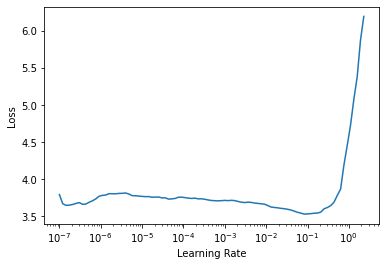

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(3,0.03, moms=(0,0,0))

epoch,train_loss,valid_loss,accuracy,time
0,2.948718,2.049491,0.271847,00:29
1,2.396746,1.816615,0.374522,00:29
2,2.112732,1.706839,0.414268,00:29


lets add some tricks to accelerate the sgd training

### a generic optimiser

fastai lightweight optimiser class

In [13]:
def sgd_cb(p, lr, **kwargs):
  p.data.add_(-lr, p.grad.data)

In [14]:
opt_func = partial(Optimizer, cbs=[sgd_cb])

In [15]:
learn = get_learner(opt_func=opt_func)
learn.fit(3,0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.699505,2.005118,0.295287,00:28
1,2.158759,1.804188,0.422420,00:29
2,1.902303,1.611248,0.462675,00:29


### Momentum

so that we dont get caught in local optima

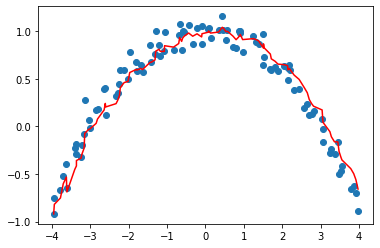

In [16]:
x = np.linspace(-4,4,100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
plt.scatter(x1, y1)
idx = x1.argsort()
beta, avg, res = 0.7, 0, []
for i in idx:
  avg = beta * avg + (1-beta) * y1[i]
  res.append(avg/(1-beta**(i+1)))
plt.plot(x1[idx], np.array(res), color='red')

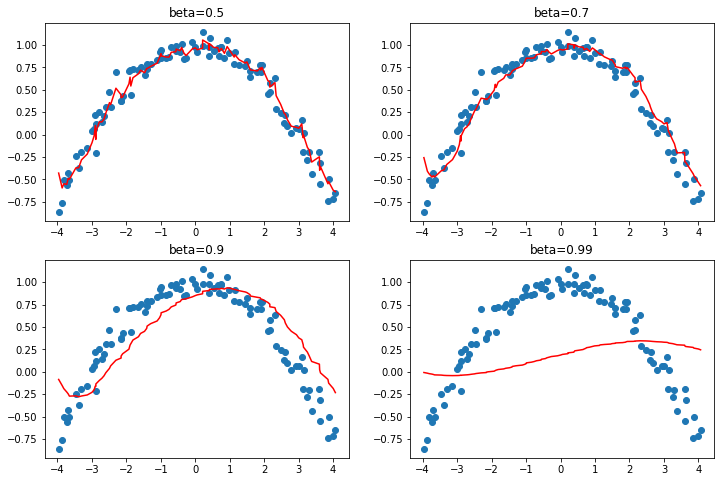

In [17]:
x = np.linspace(-4,4,100)
y = 1 - (x/3) **2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
_,axs = plt.subplots(2,2,figsize=(12,8))
betas = [0.5,0.7, 0.9,0.99]
idx = x1.argsort()
for beta, ax in zip(betas, axs.flatten()):
  ax.scatter(x1, y1)
  avg, res = 0, []
  for i in idx:
    avg = beta * avg + (1-beta) * y1[i]
    res.append(avg)
  
  ax.plot(x1[idx], np.array(res), color='red')
  ax.set_title(f'beta={beta}')

In [18]:
# so that we dont add extra gradient so we need to use another callbak

def average_grad(p,mom, grad_avg=None, **kwargs):
  if grad_avg is None:
    grad_avg = torch.zeros_like(p.grad.data)
  return {'grad_avg': grad_avg*mom + p.grad.data}

In [19]:
def momentum_step(p, lr, grad_avg, **kwargs):
  p.data.add_(-lr, grad_avg)

In [20]:
opt_func = partial(Optimizer, cbs=[average_grad, momentum_step], mom=0.9)

In [21]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3,0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.833867,2.043198,0.306497,00:29
1,2.440737,1.866800,0.390064,00:29
2,2.114511,1.664708,0.447643,00:29


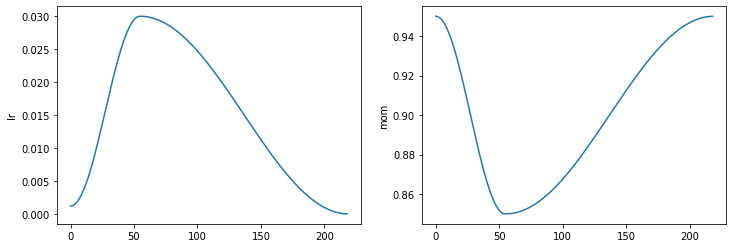

In [23]:
learn.recorder.plot_sched()

### RMS prop

another variant of SGD by Geoffrey Hinton , it uses adaptive learning rate

In [24]:
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
  if sqr_avg is None:
    sqr_avg = torch.zeros_like(p.grad.data)
  return {'sqr_avg': sqr_avg*sqr_mom + p.grad.data ** 2}


In [26]:
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
  denom = sqr_avg.sqrt().add_(eps)
  p.data.addcdiv_(-lr, p.grad, denom)
opt_func = partial(Optimizer, cbs=[average_sqr_grad, rms_prop_step], sqr_mom=0.99, eps=1e-7)

In [28]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3,0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.791251,2.505056,0.311847,00:29
1,2.148765,2.043657,0.441019,00:30
2,1.798612,1.512300,0.520764,00:29


### Adam

Adam mixes the ideas of SGD with momentum and RMSProp together  this is used in fastai

### USed with weight decay
L2 regularisation

## creating a Callback

In [29]:
class ModelResetter(Callback):
  def begin_train(self):
    self.model.reset()
  
  def begin_validate(self):
    self.model.reset()
  

In [30]:
class RNNRegularizer(Callback):
  def __init__(self, alpha=0., beta=0.):
    self.alpha, self.beta = alpha, beta
  
  def after_pred(self):
    self.raw_out, self.out = self.pred[1], self.pred[2]
    self.learn.pred = self.pred[0]
  
  def after_loss(self):
    if not self.training:
      return
    
    if self.alpha != 0.:
      self.learn.loss += self.alpha * self.out[-1].float().pow(2).mean()
    if self.beta != 0.:
      h = self.raw_out[-1]
      if len(h)>1:
        self.learn.loss += self.beta * (h[:,1:] - h[:,:-1]).float().pow(2).mean()


### Callback to skip over a back

In [31]:
class TerminateOnNaNCallback(Callback):
  run_before = Recorder
  def after_batch(self):
    if torch.isinf(self.loss) or torch.isnan(self.loss):
      raise CancelFitException